In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'gnomad_loeuf_genes',
        root = '..'
    )

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
snakemake.input['loeuf_decile']

'/data/homezvol2/mcelik/Projects/rnawg/data/results/gnomad/loeuf_decile.csv'

In [4]:
df_loeuf_genes = pd.read_csv(snakemake.input['loeuf_decile']).set_index('gene_id')

In [5]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


with ProgressBar():
    df_polya = dd.read_csv(snakemake.input['variant_polya']).compute()
    
df_polya = df_polya[~df_polya['Start'].isna()]

[########################################] | 100% Completed |  0.2s


In [6]:
#df_polya = df_polya[df_polya['signal'] == 'AATAAA']

In [7]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


with ProgressBar():
    df_utr = dd.read_csv(snakemake.input['variant_3utr']).compute()
    
df_utr = df_utr[~df_utr['Start'].isna()]

[########################################] | 100% Completed |  0.2s


In [8]:
df_utr = df_utr[df_utr['count'] > 0]

In [9]:
df_utr['length'] = df_utr['End'] - df_utr['Start']
df_utr = df_utr.groupby('gene_id').sum()
df_utr['rate_utr'] = df_utr['count'] / df_utr['length']

In [10]:
df_polya['length'] = df_polya['End'] - df_polya['Start']
df_polya = df_polya.groupby('gene_id').sum()
df_polya['rate_polya'] = df_polya['count'] / df_polya['length']

In [14]:
df = df_utr[['rate_utr']].join(df_loeuf_genes).join(df_polya[['rate_polya']])

In [15]:
df = df[~df.isna().any(axis=1)]
df

,rate_utr,oe_lof_upper_bin,rate_polya
gene_id,,,
ENSG00000000419.12,0.115385,4.0,0.666667
ENSG00000000457.13,0.142438,2.0,0.333333
ENSG00000000938.12,0.127582,2.0,0.000000
ENSG00000001167.14,0.030710,2.0,0.000000
ENSG00000001460.17,0.200617,7.0,0.000000
...,...,...,...
ENSG00000269113.3,0.126338,2.0,0.000000
ENSG00000270617.1,0.190588,7.0,0.500000
ENSG00000270898.5,0.145161,4.0,0.000000


In [16]:
df['ratio'] = df['rate_polya'] / df['rate_utr']

In [17]:
df['oe_lof_upper_bin'] = df['oe_lof_upper_bin'].astype(int).astype(str)

<AxesSubplot:xlabel='oe_lof_upper_bin', ylabel='rate_utr'>

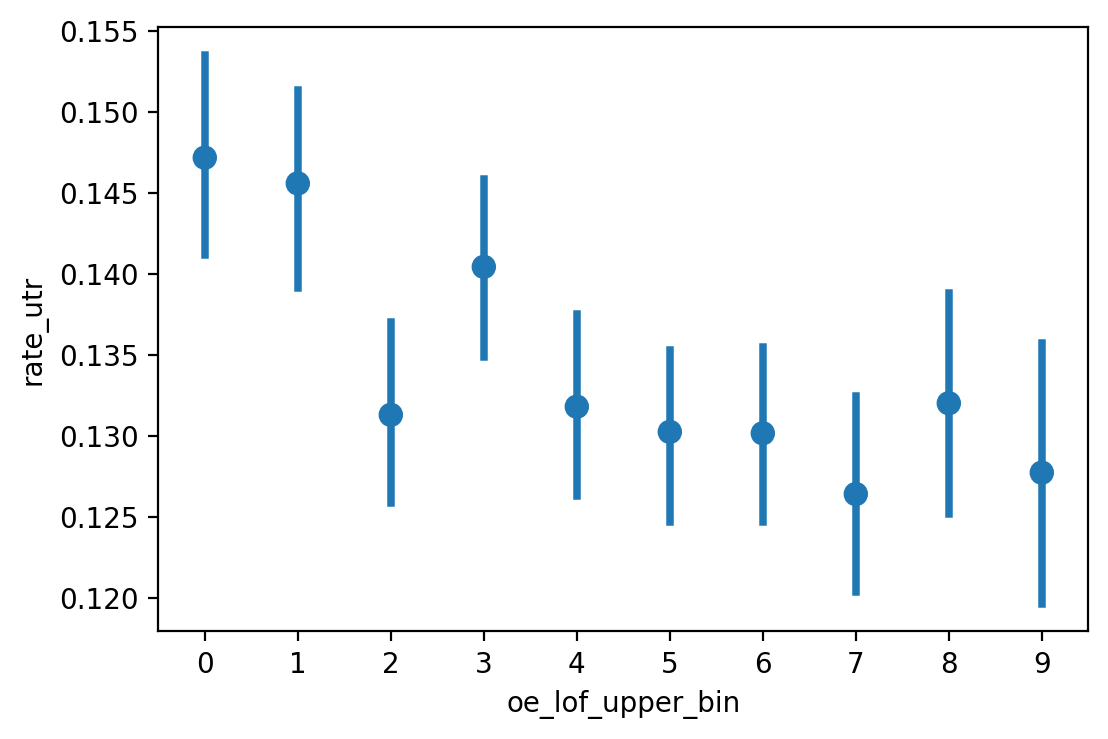

In [18]:
plt.figure(figsize=(6, 4), dpi=200)

sns.pointplot(x="oe_lof_upper_bin", y="rate_utr", data=df.sort_values('oe_lof_upper_bin'), join=False)

<AxesSubplot:xlabel='oe_lof_upper_bin', ylabel='rate_polya'>

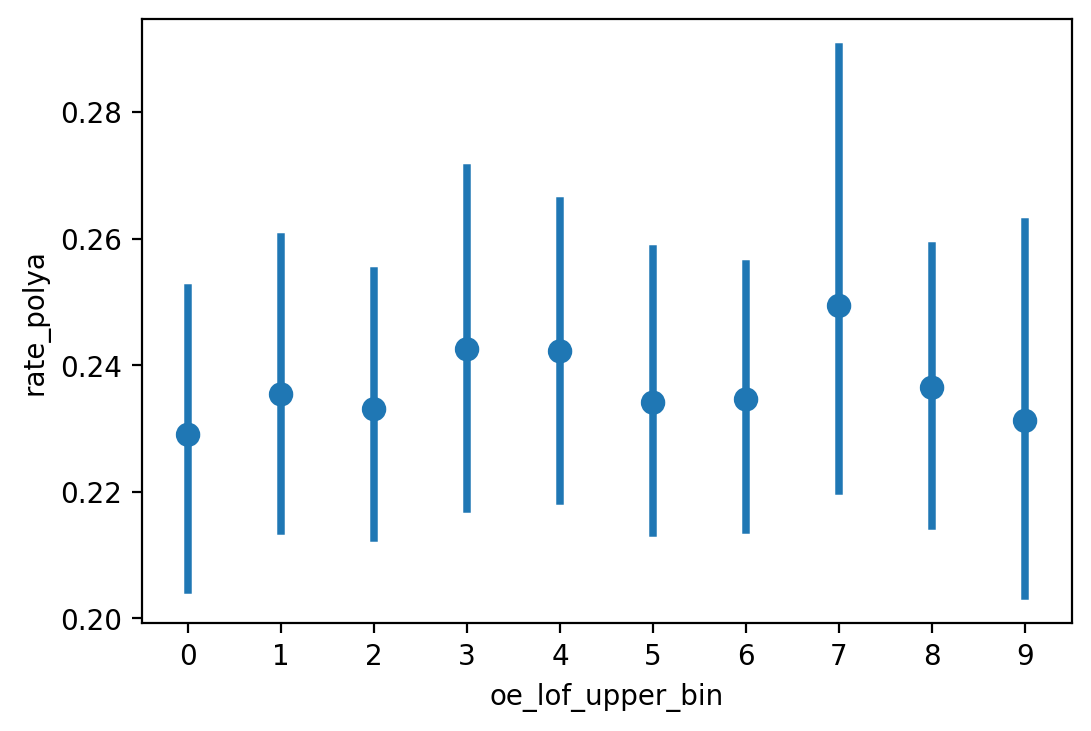

In [19]:
plt.figure(figsize=(6, 4), dpi=200)

sns.pointplot(x="oe_lof_upper_bin", y="rate_polya", data=df.sort_values('oe_lof_upper_bin'), join=False)

<AxesSubplot:xlabel='oe_lof_upper_bin', ylabel='ratio'>

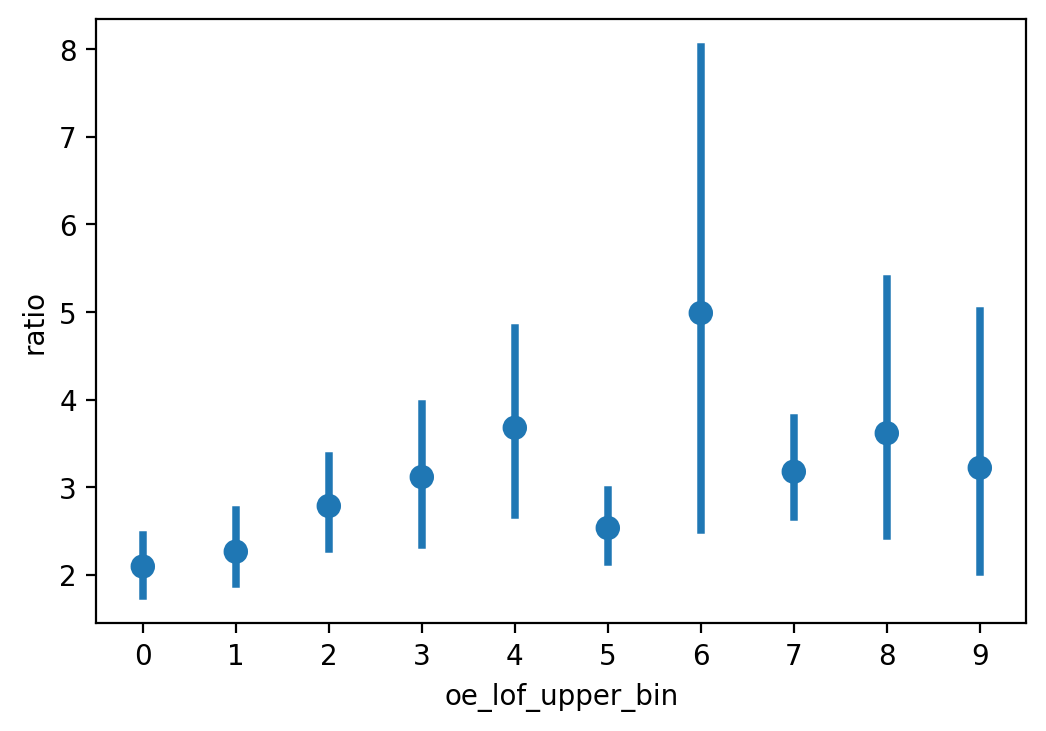

In [21]:
import seaborn as sns
plt.figure(figsize=(6, 4), dpi=200)

sns.pointplot(x="oe_lof_upper_bin", y="ratio", data=df.sort_values('oe_lof_upper_bin'), join=False)